In [1]:
import pydot
import numpy as np
from IPython.display import display, Javascript, SVG
from pydrake.examples.manipulation_station import ManipulationStation
from manipulation.scenarios import (
    AddIiwa, AddShape
)
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, AddMeshcatTriad
)
from pydrake.all import (
    Adder, Frame,
    AddMultibodyPlantSceneGraph, BasicVector, DiagramBuilder, MeshcatVisualizerCpp, MeshcatVisualizerParams, Parser, 
    RollPitchYaw, RigidTransform, RevoluteJoint, Sphere, Simulator, InverseDynamicsController, MultibodyPlant, PiecewisePolynomial,
    PiecewiseQuaternionSlerp, TrajectorySource, Quaternion,
    RotationMatrix, Rgba, LeafSystem, Integrator, PassThrough, Demultiplexer, JacobianWrtVariable, Multiplexer, SceneGraph, StateInterpolatorWithDiscreteDerivative
)
import pydrake.all

import pandas as pd

def dataframe(trajectory, times, names):
    assert trajectory.rows() == len(names)
    values = trajectory.vector_values(times)
    data = {'t': times }
    for i in range(len(names)):
        data[names[i]] = values[i,:]
    return pd.DataFrame(data)

import iiwa_rock_climbing.utils

In [2]:
meshcat = StartMeshcat()

In [34]:
BASE_MASS = 20000000
TIME_STEP = 0.001
INITIAL_JOINT_POSITIONS = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]

APPROACH_VECTOR = [[-0.15, 0, 0.5], [-0.15, 0, 0,]] # Rock frame
CONTACT_POSITION = [-1.50000000e-01,  5.49047152e-17, 1.05864376e-01] # Rock frame
GRIPPER_ORIENTATION = [1, 0, 0, 0]

In [35]:
def AddIiwaWithHook(plant, collision_model="with_box_collision", floating=True): #no_collision
    sdf_path = "iiwa_rock_climbing/models/iiwa_description/iiwa7/" + \
        f"iiwa7_{collision_model}.sdf"

    parser = Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path)
    # Set default positions:
    q0 = INITIAL_JOINT_POSITIONS
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):       
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1
            
    gripper = parser.AddModelFromFile("iiwa_rock_climbing/models/hook_convex/hook_convex.sdf", model_name="hook")
        
    # Weld gripper to iiwa
    plant.WeldFrames(
        plant.GetFrameByName("iiwa_link_7"), 
        plant.GetFrameByName("hook_link"), 
        RigidTransform(RollPitchYaw(0, -np.pi/2, 0), [-0.05, 0, 0.04]))
        
    # For gripper inline
    # RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.07]))
    
    # Weld iiwa to world
    if not floating:
        plant.WeldFrames(plant.world_frame(), 
                         plant.GetFrameByName("iiwa_link_0"))

    return iiwa

def AddFloatingBase(plant, iiwa, mass=BASE_MASS):
    base = AddShape(plant, pydrake.geometry.Box(0.2,0.2,0.2), "mobile_base", 
                    mass=mass, mu=1, color=[.5, .5, .9, 1.0])
    plant.WeldFrames(plant.GetFrameByName("mobile_base"), 
                     plant.GetFrameByName("iiwa_link_0"),
                     RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0.1]))
    
    
    # plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("mobile_base"))
    return base

In [36]:
def AddMeshcatSphere(meshcat,
                     path,
                     radius=0.01,
                     opacity=1.,
                     p_WP=np.array([0,0,0])):
    
    X_WP = RigidTransform(RotationMatrix(),
                          p_WP)
    meshcat.SetTransform(path, X_WP)
    meshcat.SetObject(path, Sphere(radius),
                      Rgba(1, 0, 0, opacity))

In [37]:
class StateController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        # self._G = plant.GetBodyByName("iiwa_link_7").body_frame()
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()

        # Use this port for perception-based end-effector poses
        # self.X_WG_port = self.DeclareVectorInputPort("ee_pose", BasicVector(7))
        
        self.DeclareVectorOutputPort("cartesian_force_cmd", BasicVector(6), 
                                     self.CalcForceOutput)
        self.DeclareVectorOutputPort("cartesian_pose_cmd", BasicVector(7), 
                                     self.CalcPoseOutput)

        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()
        
        self.states = ["idle", "pregrasp", "climbing"]
        self.current_state = "idle"
        
        # TODO: Add port for perception-based grasp info 
        self.approach_vector = APPROACH_VECTOR
        self.contact_position = CONTACT_POSITION
        self.contact_orientation = GRIPPER_ORIENTATION # TODO: update this
        

    def CalcForceOutput(self, context, output):
        cmd = np.zeros(6)
        
        if self.current_state=="climbing":
            # TODO
            # w_G = self.w_G_port.Eval(context)
            # v_G = self.v_G_port.Eval(context)
            # V_G = np.hstack([w_G, v_G])
            # q = self.q_port.Eval(context)
            # self._plant.SetPositions(self._plant_context, self._iiwa, q)
            # J_G = self._plant.CalcJacobianSpatialVelocity(
            #     self._plant_context, JacobianWrtVariable.kV, 
            #     self._G, [0,0,0], self._W, self._W)
            # J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
            # v = np.linalg.pinv(J_G).dot(V_G)
            pass
        
        output.SetFromVector(cmd)
        
    def CalcPoseOutput(self, context, output):
        cmd = np.zeros(7)
        
        if self.current_state=="pregrasp":
            # TODO
            pass
        
        output.SetFromVector(cmd)

In [38]:
q_vec = np.array([1,0,0,0])
p_vec = np.array([1,2,3])
q_quat = Quaternion(q_vec)
rot = RotationMatrix(q_quat)
RigidTransform(rot, p_vec)

RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[1.0, 2.0, 3.0],
)

In [39]:
a = np.array([0,1,2,3,4,5])
# (1, 5)
a[0:5]
# a.shape

array([0, 1, 2, 3, 4])

In [40]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        # self._G = plant.GetBodyByName("iiwa_link_7").body_frame()
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()
        self._base = plant.GetBodyByName("mobile_base")

        self.w_G_port = self.DeclareVectorInputPort("omega_WG", BasicVector(3))
        self.v_G_port = self.DeclareVectorInputPort("v_WG", BasicVector(3))
        self.q_port = self.DeclareVectorInputPort("iiwa_position", BasicVector(7))
        self.base_port = self.DeclareVectorInputPort("base_position", BasicVector(7))
        
        self.DeclareVectorOutputPort("iiwa_vel_cmd", BasicVector(7), 
                                     self.CalcVelOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcVelOutput(self, context, output):
        w_G = self.w_G_port.Eval(context)
        v_G = self.v_G_port.Eval(context)
        V_G = np.hstack([w_G, v_G])
        q = self.q_port.Eval(context)
        
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        
        # Jacobian shape is (6 rows, 13 cols) 
        # rows = spatial velocities (roll, pitch, yaw, x, y, z)
        # cols = derivatives with respect to generalized velocities
        # iiwa_start = 6
        # iiwa_end = 12
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kV, 
            self._G, [0,0,0], self._W, self._W)
        J_G = J_G[:,self.iiwa_start:self.iiwa_end+1] # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)
        
class PassthroughPrinter(LeafSystem):
    def __init__(self, dim=7):
        LeafSystem.__init__(self)
        self.in_port = self.DeclareVectorInputPort("input_port", BasicVector(dim))
        self.out_port = self.DeclareVectorOutputPort("output_port", BasicVector(dim), 
                                     self.CalcOutput)

    def CalcOutput(self, context, output):
        in_data = self.in_port.Eval(context)
        print("PORT_DEBUGGER:", in_data)
        output.SetFromVector(in_data)        

In [41]:
class TorqueController(LeafSystem):
    """
    Torque controller - all translation and orientation axes are PD-position 
    controlled except for Z axis 
    
    inputs: 
    - force magnitude (1)
    
    - approach vector start (3)
    - approach vector end (3)
    - desired gripper orientation (with respect to rock hold) (4)
    - rock hold pose (7)
    
    
    """
    def __init__(self, plant, force_z=3):
        LeafSystem.__init__(self)
        self._plant = plant 
        self._plant_context = plant.CreateDefaultContext() 
        self._iiwa = plant.GetModelInstanceByName("iiwa7")
        self._G = plant.GetFrameByName("hook_link")
        self._W = plant.world_frame()
        self._WGstart = self._plant.GetFrameByName("WGstart")
        self._WGstart_body = self._plant.GetBodyByName("WGstart")
        
        self._fz_des = force_z

        # Measurements
        self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(7))
        self.DeclareVectorInputPort("iiwa_velocity_measured", BasicVector(7))
        self.DeclareVectorInputPort("rock_pose_measured", BasicVector(7))
        
        # Commands
        self.DeclareVectorInputPort("approach_start_cmd", BasicVector(3))
        self.DeclareVectorInputPort("approach_end_cmd", BasicVector(3))
        self.DeclareVectorInputPort("gripper_orientation_cmd", BasicVector(4))

        # Outputs
        self.DeclareVectorOutputPort("iiwa_torque_cmd", BasicVector(7),
                                     self.CalcTorqueOutput)

    def CalcTorqueOutput(self, context, output):    
        # Read inputs 
        q_now      = self.get_input_port(0).Eval(context) # iiwa_position_measured
        v_now      = self.get_input_port(1).Eval(context) # iiwa_velocity_measured
        X_WR       = self.get_input_port(2).Eval(context) # rock_pose_measured
        p_WGstart  = self.get_input_port(3).Eval(context) # approach_start_cmd
        p_WGend    = self.get_input_port(4).Eval(context) # approach_end_cmd
        R_WG       = self.get_input_port(5).Eval(context) # gripper_orientation_cmd
     
        self._plant.SetPositions(self._plant_context, self._iiwa, q_now)

        # Update approach reference frame
        X_WGstart = iiwa_rock_climbing.utils.CreatePoseFromVector(R_WG, p_WGstart)
        self._plant.SetFreeBodyPose(self._plant_context, self._WGstart_body, X_WGstart)
        
        # Convert joint space quantities to Cartesian quantities ------------------------
        # TODO: Use perception here
        X_WGnow = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)
        p_des = X_WGnow.translation()
        r_des = RollPitchYaw(X_WGnow.rotation())

        # Convert to Gstart frame
        X_GstartGnow = X_WGstart.inverse() @ X_WGnow
        
        rpy_now = RollPitchYaw(X_GstartGnow.rotation()).vector()
        p_xyz_now = X_GstartGnow.translation()

        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context, JacobianWrtVariable.kQDot, 
            self._G, [0,0,0], self._WGstart, self._WGstart) #self._W, self._W)
     
        # Only select relevant terms. We end up with J_G of shape (6,7). 
        # Rows correspond to (roll, pitch, yaw x, y, z).
        # Columns correspond to (q0, q1, q2, q3, q4, q5, q6) (qdot)
        # Jacobian dimensions: 6 x 14 
        J_G = J_G[:,7:14]
        v_xyzrpy_now = J_G.dot(v_now) # convert velocity to cartesian space (dim 6)

        p_xyzrpy_now = np.array([rpy_now[0], rpy_now[1], rpy_now[2],
                                 p_xyz_now[0], p_xyz_now[1], p_xyz_now[2]])

        # TODO: Make force along gripper axis, not world #############
        F_pxz = self.ComputeCtrl(p_xyzrpy_now, v_xyzrpy_now, 
                                 px_des=p_des[0], py_des=p_des[1], fz_des=self._fz_des,
                                 rx_des=r_des.roll_angle(), ry_des=r_des.pitch_angle(), rz_des=r_des.yaw_angle())

        # Convert back from cartesian gripper to joint coordinates
        tau_cmd = J_G.T.dot(F_pxz)
        output.SetFromVector(tau_cmd)

    def ComputeCtrl(self, p_xyzrpy_now, v_xyzrpy_now, 
                    px_des, py_des, fz_des,
                    rx_des, ry_des, rz_des):
        """Compute control action given current position and velocities, as well as 
        desired x-direction position p_des(t) / desired z-direction force f_des. 
        You may set theta_des yourself, though we recommend regulating it to zero. 
        Input:
        - p_pxz_now: np.array (dim 6), global position of the finger. [thetax, thetay, thetaz, px, py, pz] 
        - v_pxz_now: np.array (dim 6), global velocity of the finger. [wx, wy, wz, vx, vy, vz] 
        - x_des: float, desired position of the finger along the x-direction. 
        - f_des: float, desired force on the book along the z-direction. 
        Output:
        - u    : np.array (dim 3), spatial torques to send to the manipulator. [tau_y, fx, fz] 
        """
#         Kp_x = 30
#         Kd_x = 25

#         Kp_y = 10
#         Kd_y = 5

#         thetay, px, pz = p_pxz_now
#         wy, vx, vz = v_pxz_now

#         # PD controller x-dir
#         fx = Kp_x * (x_des - px) - Kd_x * vx

#         # PD controller theta-y
#         tau_y = Kp_y * (0 - thetay) - Kd_y * wy

#         # Open-loop controller z-dir
#         fz = -f_des

#         # print("Positions")
#         # print([thetay, px])

#         # print("Deltas")
#         # print([wy, vx])

#         # print("Desired")
#         # print(f_des, x_des)

#         u = np.array([tau_y, fx, 0])
#         # u = np.array([tau_y, fx, fz])
#         # u = np.array([0, 0, fz])
        u = np.zeros(6)
        return u
        

In [42]:
class IIWA_Climber():
    def __init__(self, traj=None):
        self.simulator = None
        
        builder = DiagramBuilder()
        
        # Plant setup ####################################################
        self.plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=TIME_STEP)
        parser = Parser(self.plant)
        
        visualizer = MeshcatVisualizerCpp.AddToBuilder(
            builder, 
            scene_graph, 
            meshcat,
            MeshcatVisualizerParams(delete_prefix_initialization_event=False))
        
        # World setup ----------------------
        rock = parser.AddModelFromFile("iiwa_rock_climbing/models/bowl_convex/bowl_convex.sdf", model_name="bowl")
        
        # Weld rock to world
        self.plant.WeldFrames(
            self.plant.world_frame(), 
            self.plant.GetFrameByName("bowl_link"),
            RigidTransform(RollPitchYaw(0, 0, 0), [0.57, 0, 0.25]))
        
        # Add reference frame
        parser.AddModelFromFile("iiwa_rock_climbing/models/reference_frame/WGstart_frame.sdf", model_name="WGstart_frame")
        self.wg_start_frame = self.plant.GetFrameByName("WGstart")
        self.wg_start_body = self.plant.GetBodyByName("WGstart")
        self.plant.SetDefaultFreeBodyPose(self.wg_start_body, RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0]))
              
        
        # Iiwa setup ------------------------
        self.iiwa = AddIiwaWithHook(self.plant)
        base = AddFloatingBase(self.plant, self.iiwa)
                
        self.plant.gravity_field().set_gravity_vector([0., 0., 0.])    
        self.plant.Finalize()

        #####################################################################
        
       
        
        # Export the iiwa "state" outputs.
        num_iiwa_positions = self.plant.num_positions(self.iiwa)
        demux = builder.AddSystem(Demultiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.plant.get_state_output_port(self.iiwa), demux.get_input_port())    
        iiwa_position_port = demux.get_output_port(0)
        builder.ExportOutput(iiwa_position_port, "iiwa_position_measured")
        iiwa_velocity_port = demux.get_output_port(1)
        builder.ExportOutput(iiwa_velocity_port, "iiwa_velocity_estimated")
        iiwa_state_port = self.plant.get_state_output_port(self.iiwa)
        builder.ExportOutput(iiwa_state_port, "iiwa_state_estimated")       
        
        # Export the base "state" outputs.
        base_demux = builder.AddSystem(Demultiplexer([7, 6])) # 7 for position, 6 for velocity state of floating base
        builder.Connect(self.plant.get_state_output_port(self.iiwa), base_demux.get_input_port())    
        base_position_port = base_demux.get_output_port(0)
        base_velocity_port = base_demux.get_output_port(1)
        
        # -----------------------------------------------------------------------------------
        # Set up "dummy" controller plant (inverse dynamics requires fully acutated plant)        
        self.controller_plant = MultibodyPlant(time_step=TIME_STEP)
        self.controller_plant.gravity_field().set_gravity_vector([0., 0., 0.])    
        self.controller_iiwa = AddIiwaWithHook(self.controller_plant, floating=False)
        controller_parser = Parser(self.controller_plant)
        self.controller_plant.Finalize()       
        
        # Add the iiwa controller
        self.iiwa_controller = builder.AddSystem(
            InverseDynamicsController(
                self.controller_plant,
                kp=[100]*num_iiwa_positions,
                ki=[1]*num_iiwa_positions,
                kd=[20]*num_iiwa_positions,
                has_reference_acceleration=False))
        self.iiwa_controller.set_name("iiwa_controller");
        
        builder.Connect(
            self.plant.get_state_output_port(self.iiwa), self.iiwa_controller.get_input_port_estimated_state())
        # builder.Connect(self.iiwa_controller.get_output_port_control(),
        #                 self.plant.get_actuation_input_port())        

        # Add discrete derivative to command velocities.
        desired_state_from_position = builder.AddSystem(
            StateInterpolatorWithDiscreteDerivative(
                num_iiwa_positions, TIME_STEP, suppress_initial_transient=True))
        desired_state_from_position.set_name("desired_state_from_position")
        builder.Connect(desired_state_from_position.get_output_port(),      
                        self.iiwa_controller.get_input_port_desired_state())
        
        
        self.controller = builder.AddSystem(PseudoInverseController(self.plant))
        
        # Feed-forward torque ------------------------------------------------------------
        torque_adder = builder.AddSystem(Adder(2, num_iiwa_positions))
        builder.Connect(self.iiwa_controller.get_output_port_control(),
                        torque_adder.get_input_port(0))
        # Use a PassThrough to make the port optional (it will provide zero values if not connected).
        # torque_passthrough = builder.AddSystem(PassThrough([0]*num_iiwa_positions))
        # builder.Connect(torque_passthrough.get_output_port(),
        #                 torque_adder.get_input_port(1))
        # builder.ExportInput(torque_passthrough.get_input_port(), 
        #                     "iiwa_feedforward_torque")
        builder.Connect(torque_adder.get_output_port(),
                        self.plant.get_actuation_input_port(self.iiwa))


        # Add torque controller ---------------------------------------------------
        self.torque_controller = builder.AddSystem(TorqueController(self.plant))
        
        builder.Connect(iiwa_position_port, 
                        self.torque_controller.GetInputPort('iiwa_position_measured'))
        builder.Connect(iiwa_velocity_port,
                        self.torque_controller.GetInputPort('iiwa_velocity_measured'))
        # TODO: Add other ports here
        builder.Connect(self.torque_controller.GetOutputPort('iiwa_torque_cmd'),
                        torque_adder.get_input_port(1))

    
        
        
        
        # optionally add trajectory source -----------------------------------------
        if traj is not None:
            # traj_v_G = traj.get_position_trajectory().MakeDerivative()
            # traj_w_G = traj.get_orientation_trajectory().MakeDerivative()
            v_G_source = builder.AddSystem(TrajectorySource(traj['traj_v_G']))
            w_G_source = builder.AddSystem(TrajectorySource(traj['traj_w_G']))
            builder.Connect(v_G_source.get_output_port(), self.controller.GetInputPort("v_WG"))
            builder.Connect(w_G_source.get_output_port(), self.controller.GetInputPort("omega_WG"))

        self.integrator = builder.AddSystem(Integrator(7))
        builder.Connect(self.controller.get_output_port(), 
                        self.integrator.get_input_port())

        # FOR DEBUGGING
        builder.Connect(self.integrator.get_output_port(), 
                        desired_state_from_position.get_input_port())
        # printer = builder.AddSystem(PassthroughPrinter(7))
        # builder.Connect(self.integrator.get_output_port(), 
        #     printer.get_input_port())
        # builder.Connect(printer.get_output_port(), 
        #     desired_state_from_position.get_input_port())



        mux = builder.AddSystem(Multiplexer([num_iiwa_positions, num_iiwa_positions])) # 7 for position, 7 for velocity state (one for each joint)
        builder.Connect(self.integrator.get_output_port(), mux.get_input_port(0))  
        builder.Connect(self.controller.GetOutputPort("iiwa_vel_cmd"), mux.get_input_port(1))           
        builder.Connect(demux.get_output_port(0), self.controller.GetInputPort("iiwa_position"))       
        
        # State Controller ---------------------------------------------------------------
        self.smach = builder.AddSystem(StateController(self.plant))
        
        
    
        # Build ---------------------------------------------------------------------------
        self.diagram = builder.Build()
        # self.gripper_frame = self.plant.GetFrameByName("iiwa_link_7")
        self.gripper_frame = self.plant.GetFrameByName("hook_link")
        self.world_frame = self.plant.world_frame()
               
        context = self.CreateDefaultContext()
        self.diagram.Publish(context)
        
        # Set constants -------------------------------------------------------------------


        
        
    def CreateDefaultContext(self):
        context = self.diagram.CreateDefaultContext()
        plant_context = self.diagram.GetMutableSubsystemContext(self.plant, context)
        
        # TEMP--------------
        torque_controller_context = self.diagram.GetMutableSubsystemContext(self.torque_controller, context)
        self.torque_controller.GetInputPort('rock_pose_measured').\
            FixValue(torque_controller_context, np.array([1, 0, 0, 0, 0, 0, 0])) # qw qx qy qz px py pz
        self.torque_controller.GetInputPort('approach_start_cmd').\
            FixValue(torque_controller_context, np.array(APPROACH_VECTOR[0]))
        self.torque_controller.GetInputPort('approach_end_cmd').\
            FixValue(torque_controller_context, np.array(APPROACH_VECTOR[1]))
        self.torque_controller.GetInputPort('gripper_orientation_cmd').\
            FixValue(torque_controller_context, np.array(GRIPPER_ORIENTATION))
        # -----------------------
            
        # Set initial positions 
#         q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
# INITIAL_JOINT_POSITIONS        
#         self.plant.SetPositions(plant_context, self.iiwa, q0)
#         self.controller_plant.SetPositions(controller_plant_context, self.controller_iiwa, q0)
        # plant_context = self.plant.GetMyMutableContextFromRoot(context)
        # NOTE: THIS LINE OF CODE IS USEFUL FOR SETTING FIXED ROTATION VALUES
        # self.plant.get_actuation_input_port().FixValue(plant_context, np.ones(7)*0.1)        
        # Set torques to 0 if no trajectory input
        # if not self.traj:
        #     x0 = np.array([0,0,0])
        #     
        # TEMPORARY - TESTING SETTABLE STATES
        # x0 = np.hstack((q0-1, 0*q0))
        # self.iiwa_controller.GetInputPort('desired_state').FixValue(self.iiwa_controller.GetMyMutableContextFromRoot(context), x0)
#         # provide initial states
#         q0 = np.array([ 1.40666193e-05,  1.56461165e-01, -3.82761069e-05, 
#                        -1.32296976e+00, -6.29097287e-06,  1.61181157e+00, -2.66900985e-05])
#         # set the joint positions of the kuka arm
#         self.station.SetIiwaPosition(station_context, q0)
#         self.station.SetIiwaVelocity(station_context, np.zeros(7))
#         self.station.SetWsgPosition(station_context, 0.1)
#         self.station.SetWsgVelocity(station_context, 0)

#         if hasattr(self, 'integrator'):
#             self.integrator.set_integral_value(
#                 self.integrator.GetMyMutableContextFromRoot(context), 
#                 self.station.GetIiwaPosition(station_context))

        return context
    
    
    def visualize_frame(self, name, X_WF, length=0.15, radius=0.006):
        """
        visualize imaginary frame that are not attached to existing bodies
        
        Input: 
            name: the name of the frame (str)
            X_WF: a RigidTransform to from frame F to world.
        
        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatTriad(meshcat, "climber/" + name,
                        length=length, radius=radius, X_PT=X_WF)
        
    def visualize_com(self, name, p_WP, radius=0.06):
        """
        visualize center of mass
        
        Input: 
            name: the name of the frame (str)
            p_WP: a position from a point P to world.
        
        Frames whose names already exist will be overwritten by the new frame
        """
        AddMeshcatSphere(meshcat, "climber/" + name,
                         radius=radius, p_WP=p_WP)
        
        
    def get_X_WG(self, context=None):
        if not context:
            context = self.CreateDefaultContext()
        plant_context = self.plant.GetMyMutableContextFromRoot(context)
        X_WG = self.plant.CalcRelativeTransform(
                    plant_context,
                    frame_A=self.world_frame,
                    frame_B=self.gripper_frame)
        return X_WG
    
    def reset(self):
        context = self.CreateDefaultContext()
        self.simulator = Simulator(self.diagram, context)
        # self.integrator.GetMyContextFromRoot(self.simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(station.GetIiwaPosition(station_context))
        self.integrator.GetMyContextFromRoot(self.simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(INITIAL_JOINT_POSITIONS)

        self.simulator.set_target_realtime_rate(0.25)
        self.simulator.AdvanceTo(0.01)
        
    def run(self):
        self.simulator.AdvanceTo(6.0)

In [43]:
def make_gripper_frames(X_G, X_O):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and X_0["goal"], and 
    returns a X_G and times with all of the pick and place frames populated.
    """
    # Define (again) the gripper pose relative to the object when in grasp.
    # p_GgraspO = [0, 0.12, 0]
    # R_GgraspO = RotationMatrix.MakeXRotation(np.pi/2.0).multiply(
    #   RotationMatrix.MakeZRotation(np.pi/2.0))
    # X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    # X_OGgrasp = X_GgraspO.inverse()
    # # pregrasp is negative y in the gripper frame (see the figure!).
    # X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

    X_G["pick"] = X_O["goal"] #.multiply(X_OGgrasp)
    X_G["prepick"] = X_G["pick"] #.multiply(X_GgraspGpregrasp)
    # X_G["place"] = X_O["goal"].multiply(X_OGgrasp)
    # X_G["preplace"] = X_G["place"].multiply(X_GgraspGpregrasp)

    # # I'll interpolate a ahlfway orientation by converting to axis angle and halving the angle.
    # X_GprepickGpreplace = X_G["prepick"].inverse().multiply(X_G["preplace"])
    # angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    # X_GprepickGclearance = RigidTransform(AngleAxis(angle=angle_axis.angle()/2.0, axis=angle_axis.axis()), 
    #                                     X_GprepickGpreplace.translation()/2.0 + np.array([0, -0.3, 0]))
    # X_G["clearance"] = X_G["prepick"].multiply(X_GprepickGclearance)

    # Now let's set the timing
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse().multiply(X_G["prepick"])
    # times["prepick"] = times["initial"] + 10.0*np.linalg.norm(X_GinitialGprepick.translation())
    times["prepick"] = times["initial"] + 2.0#3.0*np.linalg.norm(X_GinitialGprepick.translation())
    # # Allow some time for the gripper to close.
    # times["pick_start"] = times["prepick"] + 2.0
    # times["pick_end"] = times["pick_start"] + 2.0
    # times["postpick"] = times["pick_end"] + 2.0
    # time_to_from_clearance = 10.0*np.linalg.norm(X_GprepickGclearance.translation())
    # times["clearance"] = times["postpick"] + time_to_from_clearance
    # times["preplace"] = times["clearance"] + time_to_from_clearance
    # times["place_start"] = times["preplace"] + 2.0
    # times["place_end"] = times["place_start"] + 2.0
    # times["postplace"] = times["place_end"] + 2.0
    

    return X_G, times

def make_gripper_position_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    # The syntax here is a little ugly; we need to pass in a matrix with the samples in the columns.
    # TODO(russt): Add python bindings for the std::vector constructor.
    traj = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepick"]], np.vstack([X_G["initial"].translation(), X_G["prepick"].translation()]).T)

    # # TODO(russt): I could make this less brittle if I was more careful on the names above, and just look up the pose for every time (in order)
    # traj.AppendFirstOrderSegment(times["pick_start"], X_G["pick"].translation())
    # traj.AppendFirstOrderSegment(times["pick_end"], X_G["pick"].translation())
    # traj.AppendFirstOrderSegment(times["postpick"], X_G["prepick"].translation())
    # traj.AppendFirstOrderSegment(times["clearance"], X_G["clearance"].translation())
    # traj.AppendFirstOrderSegment(times["preplace"], X_G["preplace"].translation())
    # traj.AppendFirstOrderSegment(times["place_start"], X_G["place"].translation())
    # traj.AppendFirstOrderSegment(times["place_end"], X_G["place"].translation())
    # traj.AppendFirstOrderSegment(times["postplace"], X_G["preplace"].translation())

    return traj

def make_gripper_orientation_trajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    traj = PiecewiseQuaternionSlerp();
    traj.Append(times["initial"], X_G["initial"].rotation())
    traj.Append(times["prepick"], X_G["prepick"].rotation())
    # traj.Append(times["pick_start"], X_G["pick"].rotation())
    # traj.Append(times["pick_end"], X_G["pick"].rotation())
    # traj.Append(times["postpick"], X_G["prepick"].rotation())
    # traj.Append(times["clearance"], X_G["clearance"].rotation())
    # traj.Append(times["preplace"], X_G["preplace"].rotation())
    # traj.Append(times["place_start"], X_G["place"].rotation())
    # traj.Append(times["place_end"], X_G["place"].rotation())
    # traj.Append(times["postplace"], X_G["preplace"].rotation())

    return traj




In [44]:
# X_G = {"initial": RigidTransform(RotationMatrix.MakeXRotation(-np.pi/2.0), [0, -0.25, 0.25])}
# X_O = {"initial": RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [-.2, -.75, 0.025]),
#        "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi),[.75, 0, 0.025])}

# GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 0.55])
# GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 1])
# GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([-np.pi,0,np.pi/2.0])),[.05, -0.70, 0.5])
GOAL_POSE = RigidTransform(RotationMatrix(RollPitchYaw([0,np.pi/2.0,0])),[0.5, 0, 0.5])

climber = IIWA_Climber()
X_G = {"initial": climber.get_X_WG()}
# X_O = {"initial": climber.get_X_WG(),
#        "goal": climber.get_X_WG()}#GOAL_POSE}
X_O = {"initial": climber.get_X_WG(),
       "goal": GOAL_POSE}

X_G, times = make_gripper_frames(X_G, X_O)
print(X_G)
print(times)
print(f"Sanity check: The entire maneuver will take {times['prepick']} seconds to execute.")
# X_G
# times



{'initial': RigidTransform(
  R=RotationMatrix([
    [0.23924932921398237, -1.2245343671739527e-16, 0.9709581651495911],
    [3.116556001003673e-16, 1.0000000000000002, 1.1240817377107382e-16],
    [-0.9709581651495911, 2.0150049340510336e-16, 0.23924932921398237],
  ]),
  p=[0.5022023974523409, 1.601373384602141e-16, 0.8398319536242677],
), 'pick': RigidTransform(
  R=RotationMatrix([
    [6.123233995736766e-17, 0.0, 1.0],
    [0.0, 1.0, 0.0],
    [-1.0, 0.0, 6.123233995736766e-17],
  ]),
  p=[0.5, 0.0, 0.5],
), 'prepick': RigidTransform(
  R=RotationMatrix([
    [6.123233995736766e-17, 0.0, 1.0],
    [0.0, 1.0, 0.0],
    [-1.0, 0.0, 6.123233995736766e-17],
  ]),
  p=[0.5, 0.0, 0.5],
)}
{'initial': 0, 'prepick': 2.0}
Sanity check: The entire maneuver will take 2.0 seconds to execute.


In [45]:
# %tb
FrameType

NameError: name 'FrameType' is not defined

In [46]:
traj_p_G = make_gripper_position_trajectory(X_G, times)
# traj_v_G = traj_p_G.MakeDerivative()
# traj_R_G = make_gripper_orientation_trajectory(X_G, times)
# traj_w_G = traj_R_G.MakeDerivative()

data = dataframe(traj_p_G, traj_p_G.get_segment_times(), ['x','y','z'])
data

,t,x,y,z
0,0.0,0.502202,1.601373e-16,0.839832
1,2.0,0.500000,0.000000e+00,0.500000


In [47]:
# Make the trajectories


# print(X_G)
# print(X_O)
traj_p_G = make_gripper_position_trajectory(X_G, times)
# print(traj_p_G)
traj_v_G = traj_p_G.MakeDerivative()
# print(traj_v_G)

traj_R_G = make_gripper_orientation_trajectory(X_G, times)
traj_w_G = traj_R_G.MakeDerivative()

In [48]:
# p0 = [0, 0, 0]
# R0 = RotationMatrix(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=float).T)
# X_WorldCenter = RigidTransform(R0, p0)

traj = {"traj_w_G": traj_w_G,
        "traj_v_G": traj_v_G}
climber = IIWA_Climber(traj)

# climber = IIWA_Climber()

In [49]:
X_WG = climber.get_X_WG()
climber.visualize_frame('gripper_current', X_WG)
climber.visualize_frame('gripper_goal', X_O["goal"])
# climber.visualize_frame()
# climber.visualize_frame('world_center', X_WorldCenter)
# climber.visualize_com('com_test', np.array([0.5,0.5,0.5]))

In [50]:
# help(fr)
# self.plant.GetFrameByName("reference_frame_link"),
# climber.plant
# climber.plant.SetFreeBodyPose(plant_context, body1, X_WB)

In [51]:
climber.reset()

In [52]:
climber.run()

In [54]:
[-0.57101889  0.70550408 -0.03368121  0.5681985   0.33784253  0.06692104
  0.04826821]

[-0.57891973  0.70855021 -0.02846117  0.56763461  0.3441356   0.06723372
  0.04564812]

# See this for custom controller info https://stackoverflow.com/questions/68969628/confusion-about-implementing-leafsystem-with-vector-output-port-correctly

SyntaxError: invalid syntax (2739996104.py, line 1)

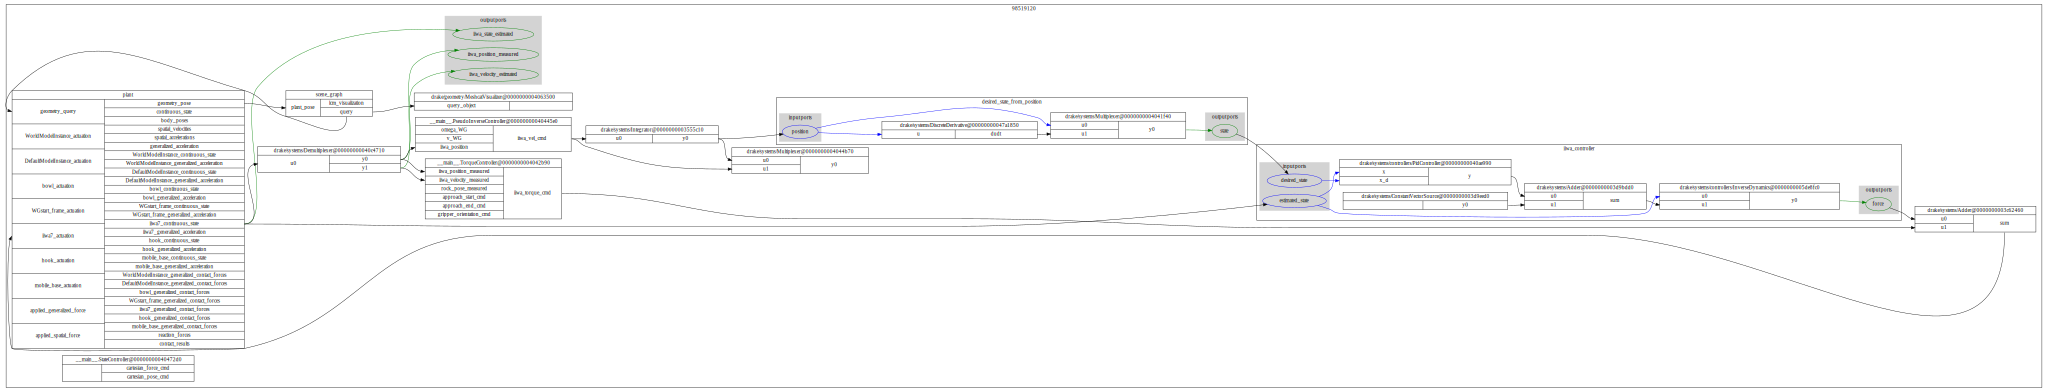

In [18]:
display(SVG(pydot.graph_from_dot_data(climber.diagram.GetGraphvizString())[0].create_svg()))

In [ ]:
# TODO: Add closed-loop controller for position in fromt of pseudo inverse controller
# take in desired position and current global positionas input, 
# NOTE: this version of the notebook shows the error in the pseudoinversecontroller - the math isn't "correct" enough to do this open-loop with a light base
# I think the pseudoinverse controller still is sending the same old joint commands, but because it's floating the inverse dynamics behaves differently?